# Fama-French Three Factor Model

In their famous paper, Fama and French expanded the CAPM model by adding two
additional factors explaining the excess returns of an asset or portfolio. The factors they
considered are:
1. The market factor (MKT): It measures the excess return of the market, analogical to the one in the CAPM.
2. The size factor, SMB (Small Minus Big): It measures the excess return of stocks with a small market cap over those with a large market cap.
3. The value factor, HML (High Minus Low): It measures the excess return of value stocks over growth stocks. Value stocks have a high book-to-market ratio, while the growth stocks are characterized by a low ratio.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf

In [16]:
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)


In [17]:
factor_df

,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.38,-2.73,0.22
1,192608,2.64,-1.47,4.14,0.25
2,192609,0.36,-1.39,0.12,0.23
3,192610,-3.24,-0.13,0.65,0.32
4,192611,2.53,-0.16,-0.38,0.31
...,...,...,...,...,...
1245,2018,-6.95,-3.29,-9.80,1.83
1246,2019,28.28,-6.13,-10.20,2.15
1247,2020,23.66,12.96,-46.46,0.45
1248,2021,23.56,-3.97,25.55,0.04


In [23]:
RISKY_ASSET = 'META'
START_DATE = '2013-12-31'
END_DATE = '2018-12-31'

In [19]:
# identify where the annual data starts
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# keep only monthly data
factor_df = factor_df[factor_df.index < start_of_annual]

In [20]:
# rename columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

# convert strings to datetime
factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m') \
                      .dt.strftime("%Y-%m")

# set index
factor_df = factor_df.set_index('date')

# filter only required dates
factor_df = factor_df.loc[START_DATE:END_DATE]

C:\Users\gabrielanatalia\AppData\Local\Temp\ipykernel_29272\1129935827.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_df['date'] = pd.to_datetime(factor_df['date'],


In [21]:
factor_df = factor_df.apply(pd.to_numeric, 
                            errors='coerce') \
                     .div(100)
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2014-01,-0.0332,0.0092,-0.0202,0.0
2014-02,0.0465,0.0037,-0.0031,0.0
2014-03,0.0043,-0.0187,0.0492,0.0
2014-04,-0.0019,-0.0420,0.0114,0.0
2014-05,0.0206,-0.0189,-0.0013,0.0


In [24]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1259 rows of data.


In [25]:
# calculate monthly returns

y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
y.head()

Date
2014-01    0.144922
2014-02    0.094135
2014-03   -0.120070
2014-04   -0.007636
2014-05    0.058883
Name: rtn, dtype: float64

In [26]:
# Merge the datasets and calculate excess returns
ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

In [27]:
# Estimate the three factor model

# define and fit the regression model 
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', 
                   data=ff_data).fit()

# print results 
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     5.063
Date:                Tue, 16 Aug 2022   Prob (F-statistic):            0.00358
Time:                        12:44:57   Log-Likelihood:                 88.252
No. Observations:                  60   AIC:                            -168.5
Df Residuals:                      56   BIC:                            -160.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0104      0.008      1.365      0.1

In [28]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [29]:
get_available_datasets()[:5]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [30]:
ff_dict = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                         start='2014-01-01')

In [31]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [32]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202206 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2022 Kenneth R. French

  0 : (102 rows x 4 cols)
  1 : Annual Factors: January-December (8 rows x 4 cols)


In [33]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2014-01,-3.32,0.92,-2.02,0.0
2014-02,4.65,0.37,-0.31,0.0
2014-03,0.43,-1.87,4.92,0.0
2014-04,-0.19,-4.20,1.14,0.0
2014-05,2.06,-1.89,-0.13,0.0


## Implementing the rolling three-factor model on a portfolio of assets

In [49]:
import pandas as pd
import yfinance as yf
import statsmodels.formula.api as smf
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt

In [35]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2009-12-31'
END_DATE = '2018-12-31'

In [36]:
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]
df_three_factor = df_three_factor.div(100)
df_three_factor.index = df_three_factor.index.format()

In [37]:
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2265 rows of data.


In [38]:
# Calculate the monthly returns on the risky assets

asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()
# reformat index for joining
asset_df.index = asset_df.index.strftime('%Y-%m')

In [41]:
# Calculate the portfolio returns:

asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, 
                                          WEIGHTS)
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2010-01,-0.088597,-0.067722,-0.145230,-0.075459,-0.094252
2010-02,0.065396,-0.055897,-0.005925,0.022145,0.006430
2010-03,0.148470,0.146706,0.076538,0.021626,0.098335
2010-04,0.111021,0.009796,-0.073036,0.042677,0.022615
2010-05,-0.016124,-0.084902,-0.076222,-0.151394,-0.082161


<AxesSubplot:xlabel='Date'>

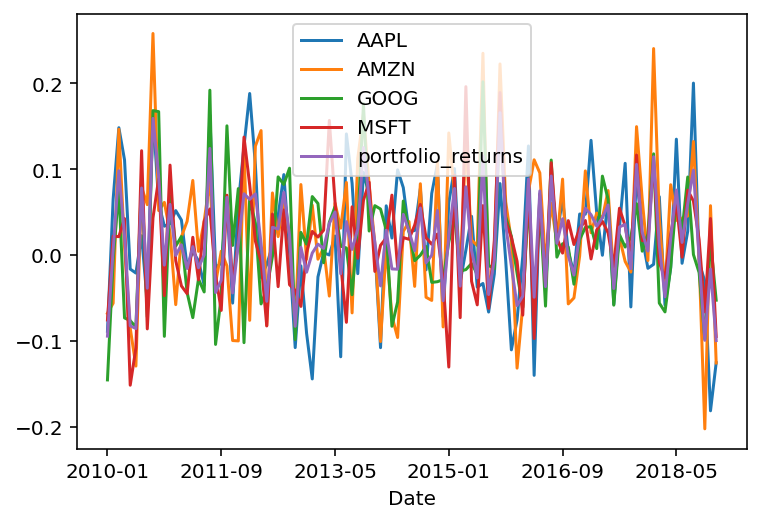

In [42]:
asset_df.plot()

In [43]:
# Merge the datasets

ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2010-01,-0.094252,-0.0336,0.0040,0.0043,0.0000,-0.094252
2010-02,0.006430,0.0340,0.0119,0.0322,0.0000,0.006430
2010-03,0.098335,0.0631,0.0148,0.0221,0.0001,0.098235
2010-04,0.022615,0.0200,0.0487,0.0289,0.0001,0.022515
2010-05,-0.082161,-0.0789,0.0009,-0.0244,0.0001,-0.082261


In [44]:
# Define a function for the rolling n-factor model

def rolling_factor_model(input_data, formula, window_size):
    '''
    Function for estimating the Fama-French (n-factor) model using a rolling window of fixed size.
    
    Parameters
    ------------
    input_data : pd.DataFrame
        A DataFrame containing the factors and asset/portfolio returns
    formula : str
        `statsmodels` compatible formula representing the OLS regression  
    window_size : int
        Rolling window length.
    
    Returns
    -----------
    coeffs_df : pd.DataFrame
        DataFrame containing the intercept and the three factors for each iteration.
    '''

    coeffs = []

    for start_index in range(len(input_data) - window_size + 1):        
        end_index = start_index + window_size

        # define and fit the regression model 
        ff_model = smf.ols(
            formula=formula, 
            data=input_data[start_index:end_index]
        ).fit()
   
        # store coefficients
        coeffs.append(ff_model.params)
    
    coeffs_df = pd.DataFrame(
        coeffs, 
        index=input_data.index[window_size - 1:]
    )

    return coeffs_df

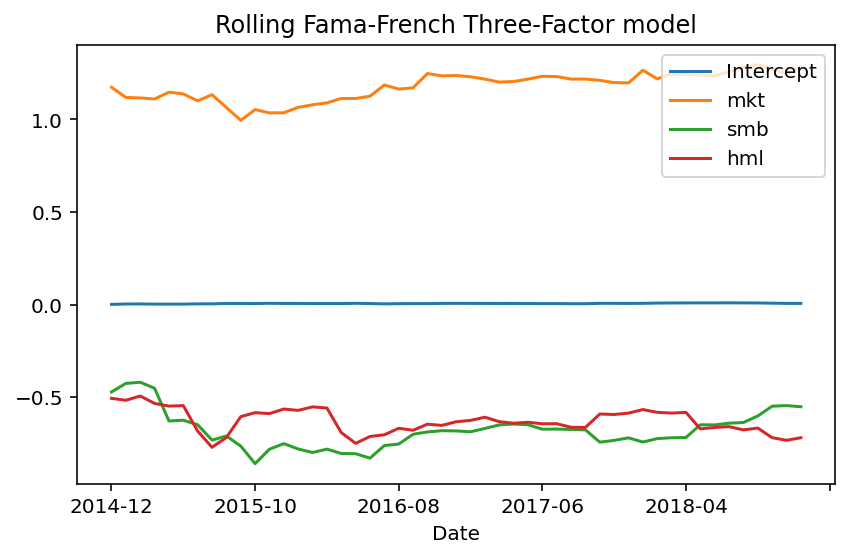

In [50]:
# Estimate the rolling three-factor model and plot the results:

MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'
results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

plt.tight_layout()
# plt.savefig('images/ch4_im8.png')
plt.show()